In [1]:
import numpy as np
import pylab as plt
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

X,y = load_mnist('./fashionmnist/')

# the dataset, we choose one class

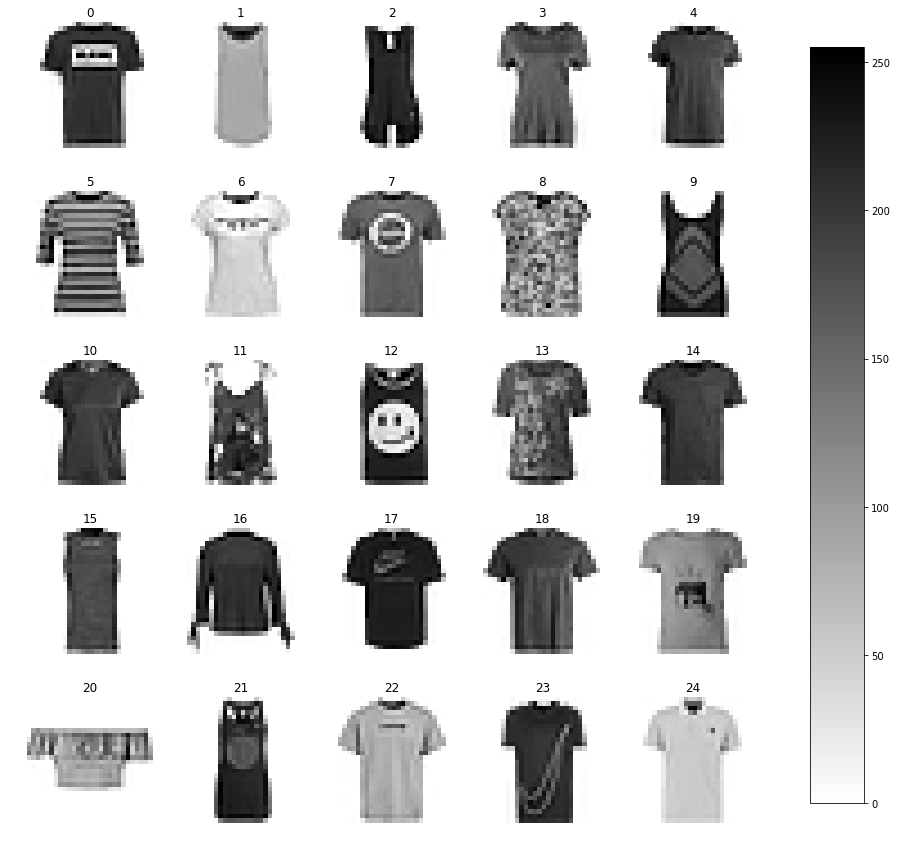

In [2]:
c = 0 # choose one of the classes 0 to 9
# suggested classes to look at : 0 tshirt, 3 dress, 7 shoe

Xc = X[y==c]
llength = int(np.sqrt(X.shape[1])) # get length of x,y for reshape

fig, axs = plt.subplots(5,5, figsize=(15, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(25):
    im = axs[i].imshow(Xc[i].reshape(llength,llength),cmap='gray_r')
    axs[i].set_title(str(i))
    axs[i].axis('off')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fname = './images/originals.png'
plt.savefig(fname,dpi=300)

# PCA decomposition

variance explained 0.81
reconstruction loss 55916.32


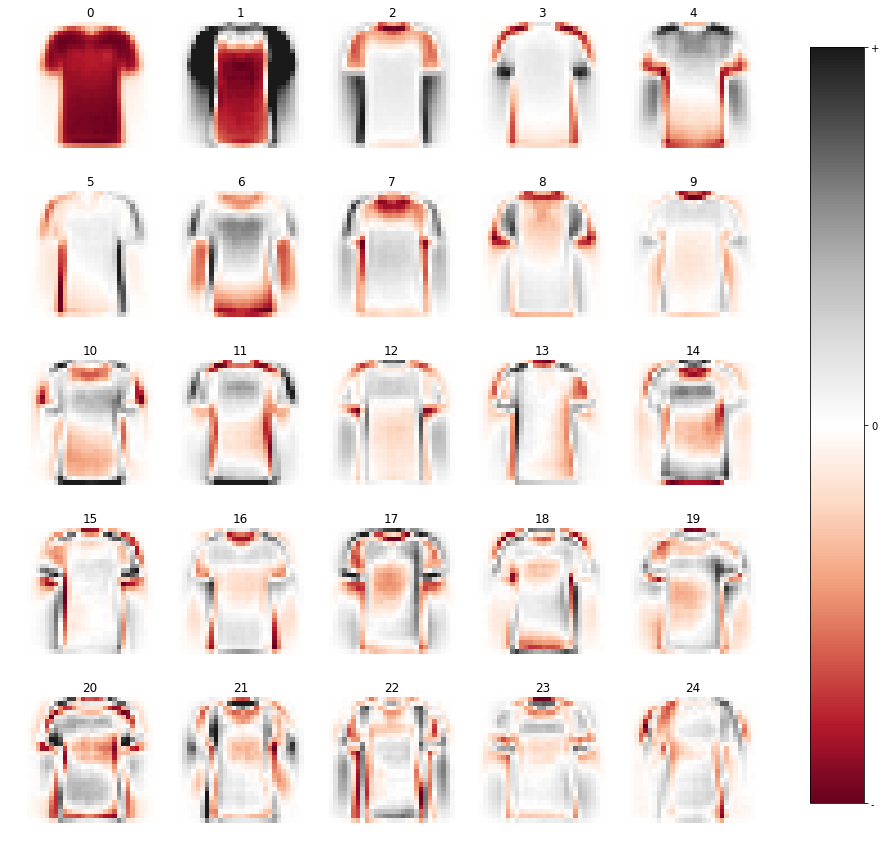

In [9]:
n_components=25
pca = PCA(n_components=n_components, svd_solver='randomized',whiten=True)

pca_encodings = pca.fit_transform(Xc)
pca_codebook = pca.components_.reshape(-1,llength,llength)
pca_reconstruction = pca.inverse_transform(pca_encodings)

fig, axs = plt.subplots(5,5, figsize=(15, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(25):
    vmin = np.min(pca_codebook[i])
    im = axs[i].imshow(pca_codebook[i],cmap='RdGy', vmin=vmin, vmax=-vmin)
    axs[i].set_title(str(i))
    axs[i].axis('off')
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[vmin, 0, -vmin])
cbar.ax.set_yticklabels(['-', '0', '+'],fontsize=10) 

fname = './images/pca_25_codebook.png'
plt.savefig(fname,dpi=300)

print(f'variance explained {pca.explained_variance_ratio_.sum():.2f}')
print(f'reconstruction loss {np.linalg.norm(Xc - pca_reconstruction):.2f}' )

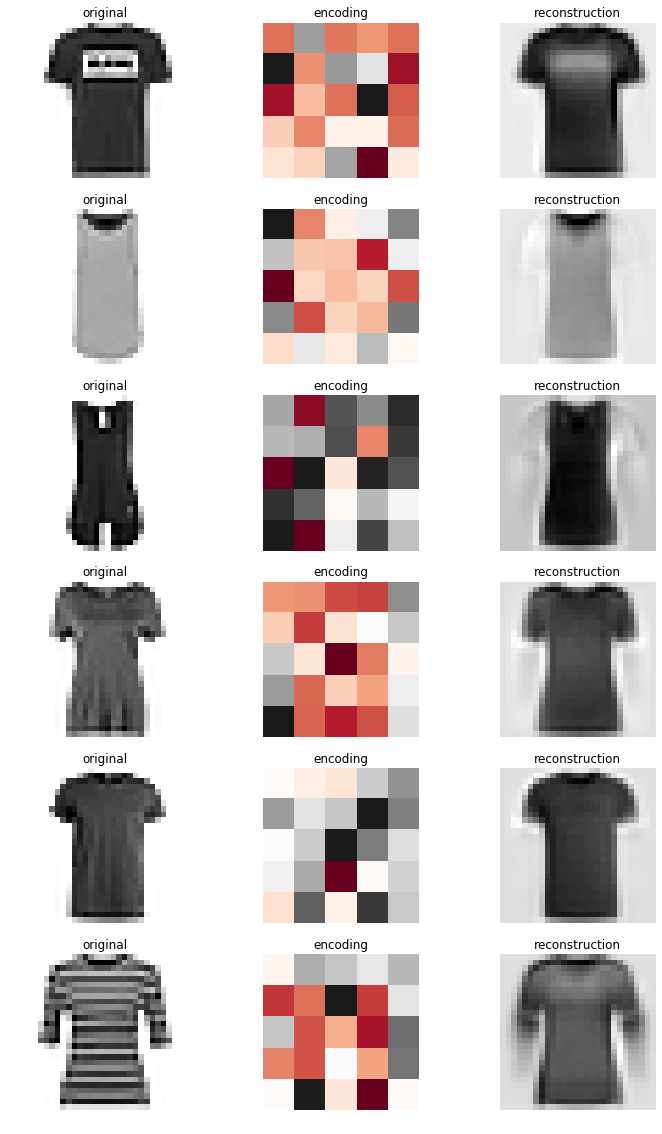

In [62]:
fig, axs = plt.subplots(6,3, figsize=(12,20), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(6):
    orig = axs[i*3].imshow(Xcm[i,:].reshape(llength,llength),cmap='gray_r')
    axs[i*3].title.set_text(f'original'); axs[i*3].axis('off')
    
    encoding = axs[i*3+1].imshow(pca_encodings[i,:].reshape(5,5),cmap='RdGy');
    axs[i*3+1].title.set_text(f'encoding'); axs[i*3+1].axis('off')
    
    reconstruction = axs[i*3+2].imshow(
        pca_reconstruction[i].reshape(llength,llength),
        cmap='gray_r')
    axs[i*3+2].title.set_text(f'reconstruction'); axs[i*3+2].axis('off')
    
fname = './images/pca_25_encoding_reconstruction.png'
plt.savefig(fname,dpi=300)

# NMF decomposition

59438.36562882681


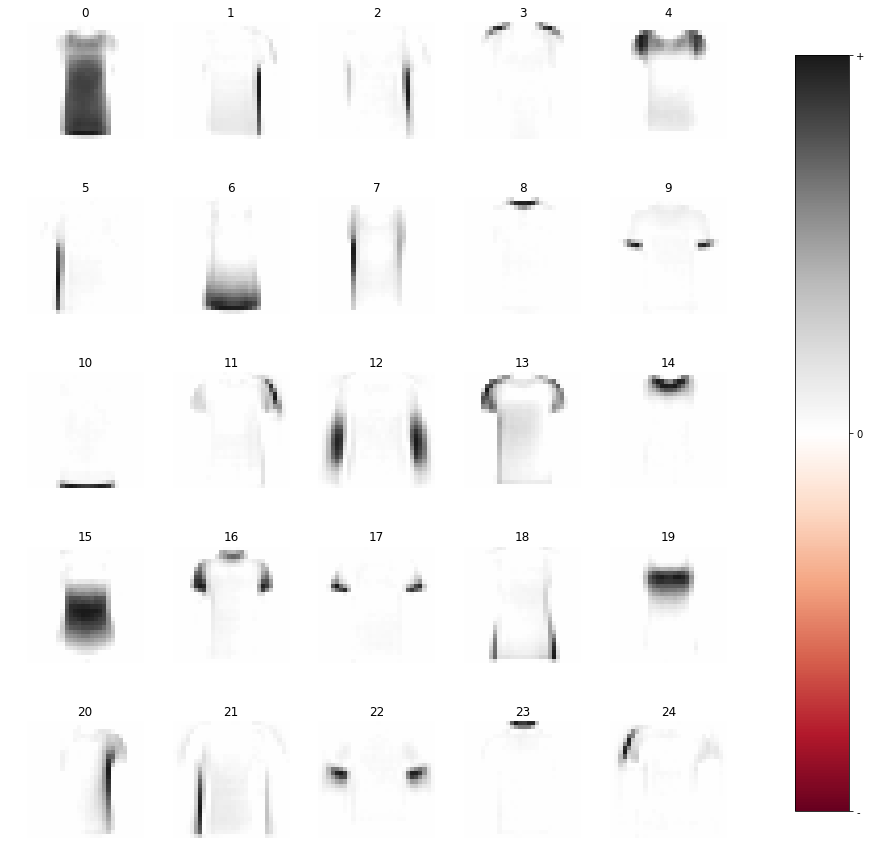

In [5]:
nmf = NMF(n_components=n_components,
          init='nndsvd', 
          tol=1e-9, 
          solver='cd', 
          max_iter=200)

nmf_encodings = nmf.fit_transform(Xc)
nmf_codebook = nmf.components_
nmf_reconstruction = nmf.inverse_transform(nmf_encodings)
nmf_encodings = nmf_encodings.reshape(-1,5,5)
nmf_codebook = nmf_codebook.reshape((-1, llength, llength))

fig, axs = plt.subplots(5,5, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(25):
    vmax = np.max(nmf_codebook[i])
    im = axs[i].imshow(nmf_codebook[i],cmap='RdGy',vmin=-vmax, vmax=vmax)
    axs[i].set_title(str(i))
    axs[i].axis('off')
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[-vmax, 0, vmax])
cbar.ax.set_yticklabels(['-', '0', '+'],fontsize=10) 

fname = './images/nmf_25_codebook.png'
plt.savefig(fname,dpi=300)
print(nmf.reconstruction_err_)

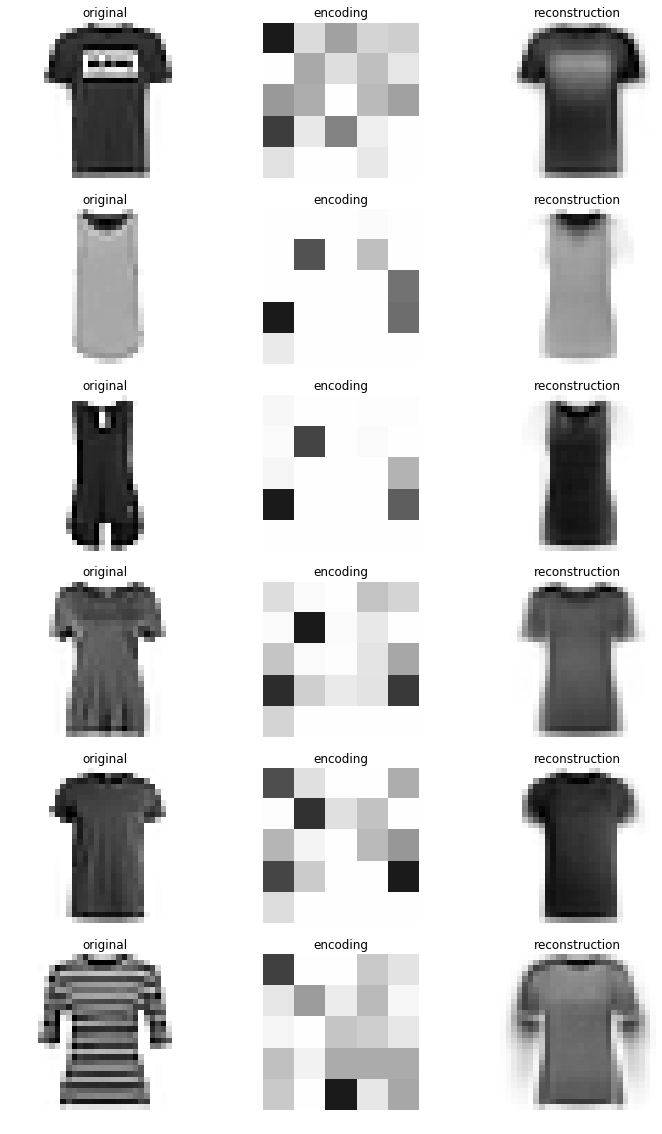

In [6]:
fig, axs = plt.subplots(6,3, figsize=(12,20), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(6):
    orig = axs[i*3].imshow(Xc[i,:].reshape(llength,llength),cmap='gray_r')
    axs[i*3].title.set_text(f'original'); axs[i*3].axis('off')
    
    vmax = np.max(nmf_encodings[i])
    encoding = axs[i*3+1].imshow(nmf_encodings[i],cmap='RdGy',vmin=-vmax,vmax=vmax);
    axs[i*3+1].title.set_text(f'encoding'); axs[i*3+1].axis('off')
    
    reco = axs[i*3+2].imshow(nmf_reconstruction[i].reshape(llength,llength),cmap='gray_r')
    axs[i*3+2].title.set_text(f'reconstruction'); axs[i*3+2].axis('off')
    
fname = './images/nmf_25_encoding_reconstruction.png'
plt.savefig(fname,dpi=300)

# vector quantization by kmeans

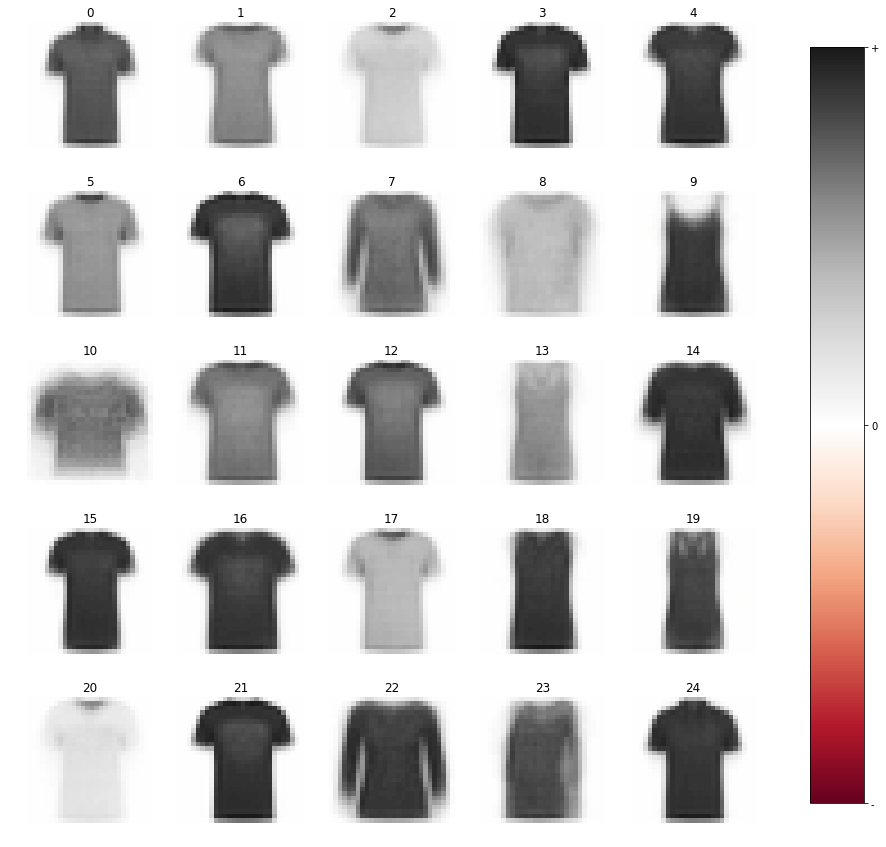

In [74]:
kmeans = KMeans(n_clusters = n_components,
                init = 'k-means++',
                n_jobs = -1)
kmeans_encodings = kmeans.fit_predict(Xc)

enc = OneHotEncoder(categories='auto')
kmeans_encodings1H = enc.fit_transform(kmeans_encodings.reshape(-1,1)).todense()
#import ipdb; ipdb.set_trace()
kmeans_encodings1H = np.array(kmeans_encodings1H)

kmeans_codebook = kmeans.cluster_centers_
kmeans_reconstruction = kmeans_encodings1H @ kmeans_codebook

fig, axs = plt.subplots(5,5, figsize=(15, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()

vmin = np.min(kmeans_codebook)
vmax = np.max(kmeans_codebook)
for i in range(25):
    im = axs[i].imshow(kmeans_codebook[i].reshape(28,28),cmap='RdGy',vmin=-vmax,vmax=vmax)
    axs[i].set_title(str(i))
    axs[i].axis('off')
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[-vmax, 0, vmax])
cbar.ax.set_yticklabels(['-', '0', '+'],fontsize=10);

fname = './images/kmeans_25_codebook.png'
plt.savefig(fname,dpi=300)

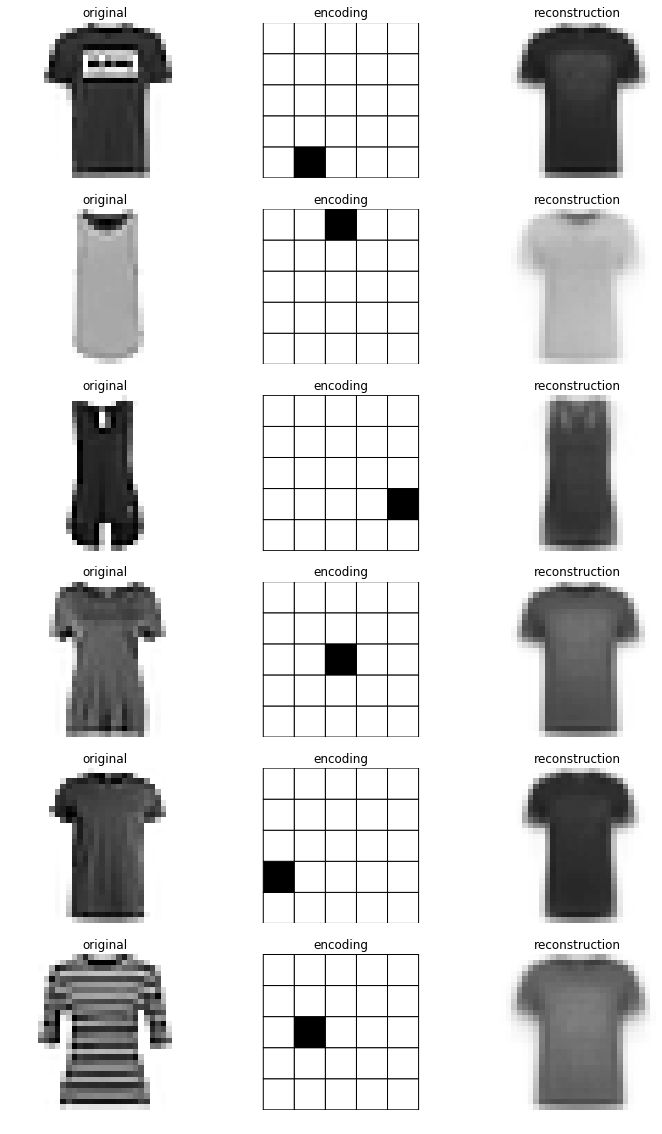

In [75]:
fig, axs = plt.subplots(6,3, figsize=(12,20), facecolor='w', edgecolor='k')
axs = axs.ravel()

vmin = np.min(Xc)
vmax = np.max(Xc)
for i in range(6):
    orig = axs[i*3].imshow(Xc[i,:].reshape(llength,llength),
                           cmap='gray_r',
                           vmin=vmin, vmax=vmax)
    axs[i*3].title.set_text(f'original'); axs[i*3].axis('off')
    
    encoding = axs[i*3+1].pcolor(
                    np.flipud(kmeans_encodings1H[i].reshape(5,5)),
                    edgecolors='k', linewidth=1,
                    cmap = 'gray_r');
    axs[i*3+1].axis('equal')
    axs[i*3+1].title.set_text(f'encoding'); axs[i*3+1].axis('off')
    
    reco = axs[i*3+2].imshow(kmeans_reconstruction[i].reshape(llength,llength),
                             cmap='gray_r',
                             vmin=vmin, vmax=vmax)
    axs[i*3+2].title.set_text(f'reconstruction'); axs[i*3+2].axis('off')
    
fname = './images/kmeans_25_encoding_reconstruction.png'
plt.savefig(fname,dpi=300)